In [12]:
from __future__ import annotations
import os
from pathlib import Path
import numpy as np
from gpaw import restart
from gpaw.lcao.pwf2 import LCAOwrap
from qtpyt.basis import Basis
from qtpyt.lo.tools import rotate_matrix, subdiagonalize_atoms, lowdin_rotation
from qtpyt.basis import Basis
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import matplotlib.pyplot as plt

In [16]:
# Getting localized orbitals and other prerequisites calculation (runs serially)

def get_species_indices(atoms,species):
    indices = []
    for element in species:
        element_indices = atoms.symbols.search(element)
        indices.extend(element_indices)
    return sorted(indices)

def create_active_hamiltonian(H, S,  index_active_region):
    # Create a list of indices to retain
    indices_to_keep = sorted(list(index_active_region))

    # Create the H_active matrix by extracting the relevant rows and columns
    H_active = H[np.ix_(indices_to_keep, indices_to_keep)]
    S_active = S[np.ix_(indices_to_keep, indices_to_keep)]

    return H_active, S_active

In [3]:
data_folder = '../output/compute_run'
# Create the folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

GPWDEVICEDIR = '../dft/device/'
GPWLEADSDIR = '../dft/leads/'
SUBDIAG_SPECIES = ("C", "N", "H")
# Define the active region within the subdiagonalized species
active = {'C': [3],'N': [3]}
lowdin = True

cc_path = Path(GPWDEVICEDIR)
pl_path = Path(GPWLEADSDIR)
gpwfile = f'{cc_path}/scatt.gpw'

In [4]:
atoms, calc = restart(gpwfile, txt=None)
fermi = calc.get_fermi_level()
nao_a = np.array([setup.nao for setup in calc.wfs.setups])
basis = Basis(atoms, nao_a)

lcao = LCAOwrap(calc)
H_lcao = lcao.get_hamiltonian()
S_lcao = lcao.get_overlap()
H_lcao -= fermi * S_lcao

Condition number: 2.8e+04


In [5]:
subdiag_indices = get_species_indices(atoms, SUBDIAG_SPECIES)

basis_subdiag_region = basis[subdiag_indices]
index_subdiag_region = basis_subdiag_region.get_indices()

extract_active_region = basis_subdiag_region.extract().take(active)
index_active_region = index_subdiag_region[extract_active_region]

np.save(f"{data_folder}/index_active_region.npy",index_active_region)


In [7]:
print(index_active_region)
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
print(index_active_region)

[1124 1147 1160 1178 1191 1204 1227 1240 1263]
[1124 1147 1160 1178 1191 1204 1227 1240 1263]


In [8]:
# Perform subdiagonalization
Usub, eig = subdiagonalize_atoms(basis, H_lcao, S_lcao, a=subdiag_indices)
H_subdiagonalized = rotate_matrix(H_lcao, Usub)
S_subdiagonalized = rotate_matrix(S_lcao, Usub)

if lowdin:
    Ulow = lowdin_rotation(H_subdiagonalized, S_subdiagonalized, index_active_region)

    H_subdiagonalized = rotate_matrix(H_subdiagonalized, Ulow)
    S_subdiagonalized = rotate_matrix(S_subdiagonalized, Ulow)

# Rotate matrices
H_subdiagonalized = H_subdiagonalized[None, ...]
S_subdiagonalized = S_subdiagonalized[None, ...]

np.save(f"{data_folder}/hs_los_lowdin.npy", (H_subdiagonalized,S_subdiagonalized))


In [14]:
BRIDGE_SPECIES = ("N", "C", "H")
bridge_indices = get_species_indices(atoms, BRIDGE_SPECIES)
basis_bridge = basis[bridge_indices]
bridge_orbital_indices = basis_bridge.get_indices()
bridge_start = bridge_orbital_indices[0]
bridge_end = bridge_orbital_indices[-1]

# Extract the bridge regions
bridge_region_H_sub = H_subdiagonalized[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]
bridge_region_S_sub = S_subdiagonalized[0, bridge_start:bridge_end+1, bridge_start:bridge_end+1]


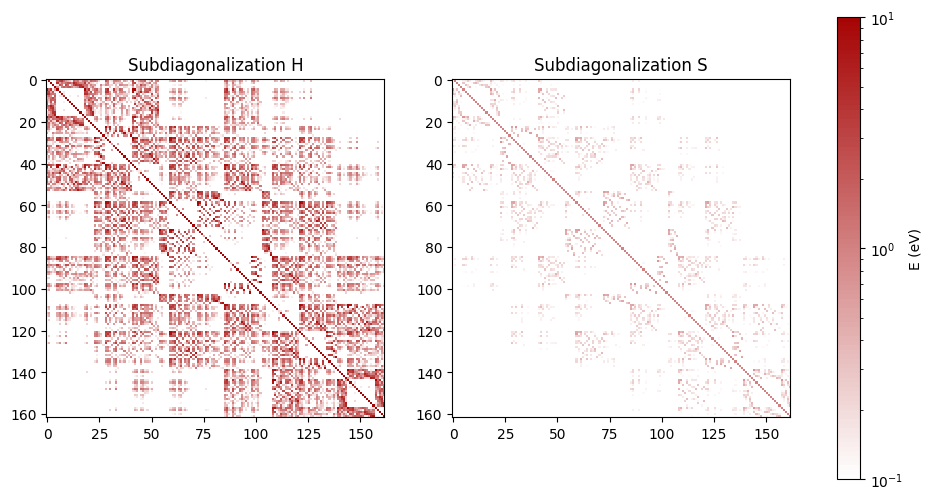

In [13]:
cmap_name = 'custom_white_red'
colors = [(1, 1, 1), (166/255, 4/255, 4/255)]
n_bins = 100
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = LogNorm(vmin=0.1, vmax=10)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(bridge_region_H_sub), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(bridge_region_S_sub), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()

### Check if active space is Lowdin orthogonalized by checking that S = Identity in the active space

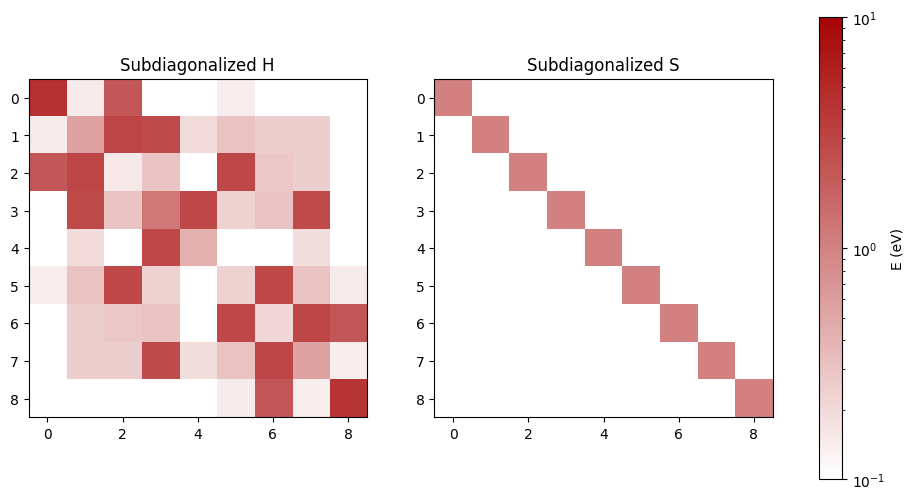

In [19]:
H_active, S_active = create_active_hamiltonian(H_subdiagonalized[0], S_subdiagonalized[0], index_active_region)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the subdiagonalized H matrix for the bridge region
cax1 = ax1.imshow(np.abs(H_active), interpolation='nearest', cmap=cm, norm=norm)
ax1.set_title("Subdiagonalized H")

# Plot the subdiagonalized S matrix for the bridge region
cax2 = ax2.imshow(np.abs(S_active), interpolation='nearest', cmap=cm, norm=norm)
ax2.set_title("Subdiagonalized S")

# Add a shared colorbar
cbar = fig.colorbar(cax2, ax=[ax1, ax2], orientation='vertical')
cbar.set_label('E (eV)')

plt.show()